In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline
from matplotlib import cm
import seaborn as sns
import datetime
from collections import Counter
from stations import load
stationData = load()
from weather import load
weather = load()

from elevation import elevationModel
dem = elevationModel()

In [2]:
%%time
# Read in DEM raster
img = np.clip(dem._raster.ReadAsArray()[::16,::16],0,None)

Wall time: 12.6 s


In [3]:
#Q1 = pd.read_csv(r'C:\Users\Ben\Documents\CaBi\2016-Q1-Trips-History-Data.csv')
#df = pd.read_csv('2014-Q3-cabi-trip-history-data.zip')

In [4]:
%%time
from glob import glob
files = glob("2016*.csv") + glob("2015*.csv") + glob("2014*.csv")
print files
frames = map(pd.read_csv, files)

['2016-Q1-Trips-History-Data.csv', '2016-Q2-Trips-History-Data.csv', '2016-Q3-Trips-History-Data-1.csv', '2016-Q3-Trips-History-Data-2.csv', '2015-Q1-Trips-History-Data.csv', '2015-Q2-Trips-History-Data.csv', '2015-Q3-cabi-trip-history-data.csv', '2015-Q4-Trips-History-Data.csv', '2014-Q4-cabi-trip-history-data.csv']
Wall time: 8.23 s


In [5]:
renameCols = {
    "Account type": "Member Type",
    "Member type": "Member Type",
    "Duration (ms)": "Duration",
    "Total duration (ms)": "Duration",
    "Subscription Type": "Member Type",
    "Subscription type": "Member Type",
    "Start Station": "Start station",
    "End Station": "End station",
    r"Bike #": "Bike number",
    r"Bike#": "Bike number"
}
def splitTimeDelta(dt):
    h,m,s = dt.split()
    return 3600*int(h[:-1]) + 60*int(m[:-1]) + int(s[:-1])

for fr in frames:
    fr.rename(columns=renameCols, inplace=True)

    if fr.Duration.dtype == np.int64:
        fr['Duration'] = fr.Duration / 1000
    else:
        fr['Duration'] = fr.Duration.apply(splitTimeDelta)
        
    for datefield in ('Start date', 'End date'):
        fr[datefield] = pd.to_datetime(fr[datefield], infer_datetime_format=True)

trips = pd.concat(frames)

In [6]:
trips.head()

,Bike number,Duration,End date,End station,End station number,Member Type,Start date,Start station,Start station number
0,W00022,301.295,2016-04-01 00:04:00,1st & Rhode Island Ave NW,31506.0,Registered,2016-03-31 23:59:00,11th & S St NW,31280.0
1,W01294,557.887,2016-04-01 00:08:00,18th St & Wyoming Ave NW,31114.0,Registered,2016-03-31 23:59:00,New Hampshire Ave & 24th St NW,31275.0
2,W01416,555.944,2016-04-01 00:08:00,18th & M St NW,31221.0,Registered,2016-03-31 23:59:00,14th & V St NW,31101.0
3,W01090,766.916,2016-04-01 00:09:00,17th & Corcoran St NW,31214.0,Registered,2016-03-31 23:57:00,34th St & Wisconsin Ave NW,31226.0
4,W21934,139.656,2016-03-31 23:59:00,27th & Crystal Dr,31009.0,Registered,2016-03-31 23:57:00,23rd & Crystal Dr,31011.0


In [7]:
stationData = stationData[['name','x','y','lat','long','railDist','closestRail','elevation','capacity','pixel']]
stationDataDC = stationData.dropna(axis=0,subset=['elevation'])
stationData.columns

Index([u'name', u'x', u'y', u'lat', u'long', u'railDist', u'closestRail',
       u'elevation', u'capacity', u'pixel'],
      dtype='object')

In [44]:
len(trips['Start station number'].unique())

408

In [9]:
#%%time
# need auto: some files are slash, some are hyphen
#for datefield in ('Start date', 'End date'):
#    trips[datefield] = pd.to_datetime(trips[datefield], format="%Y-%m-%d %H:%M")
#    trips[datefield] = pd.to_datetime(trips[datefield], infer_datetime_format=True)
trips['Duration'].dtype

dtype('float64')

In [10]:
#Q1['Duration'] = map(lambda delta: delta.seconds/60, Q1['End date'] - Q1['Start date'])
#trips['Duration'] = trips['Duration'].astype(np.float) /1000
#trips.drop('Duration (ms)', 1,inplace=True)

In [11]:
# retain only registered members
trips = trips[trips['Member Type'] == 'Registered'].drop('Member Type',1)

In [12]:
%%time
trips['date'] = trips['Start date'].apply(lambda dt: dt.date())
trips['hour'] = trips['Start date'].apply(lambda dt: dt.hour)
trips['weekday'] = trips['Start date'].apply(lambda dt: dt.isoweekday() < 6)
weekday = trips[ trips['weekday']].drop('weekday',1)
weekend = trips[ trips['weekday'] == False].drop('weekday',1)

Wall time: 30.6 s


In [13]:
morning = (trips.hour == 7) | (trips.hour == 8) | (trips.hour == 9)
afternoon = (trips.hour == 16) | (trips.hour == 17) | (trips.hour == 18)
night = (trips.hour > 21) | (trips.hour < 6)

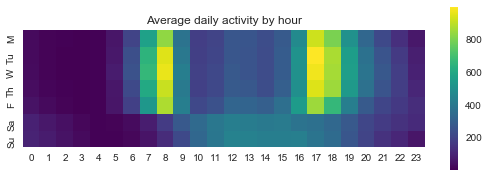

In [14]:
def dayTimeHeatmap(df, filt=None):
    if filt is None:
        filt = pd.Series(data=True, index=df.index)
#    if filt is not None:
    windyDays = df[filt].date.unique()
    counts = Counter(map(lambda date: date.isoweekday(), windyDays))
    # print counts
    df = df[filt]

#    print df.size
    byHourAndDay = df.groupby([df.date.map(lambda dt: dt.isoweekday()),
                           df.hour]).size().values.reshape((7,24))
#    if filt is not None:
    for d,count in counts.iteritems():
        byHourAndDay[d-1,:] /= count
            
    fig = plt.figure().set_size_inches(9,3)
    sns.heatmap(byHourAndDay,
           yticklabels=['M','Tu','W','Th','F','Sa','Su'],
           cmap='viridis',
           square=True,
           ax=plt.gca())
    plt.title('Average daily activity by hour')
dayTimeHeatmap(trips)

In [15]:
# Test for querying weather
#weather.loc[Q1.date.iloc[0]]
print weather.loc[trips.date.head()]

def createWeatherFilter(weatherField, predicate):
    return pd.Series(data = predicate(weather[weatherField].loc[trips.date].values),
                     index = trips.index)
#isRain = createWeatherFilter('rain', lambda x: x)
isRain = createWeatherFilter('precip', lambda x: x > 0)
isHot = createWeatherFilter('tempHigh', lambda t: t > 85)
isCold = createWeatherFilter('tempHigh', lambda t: t < 40)
isWindy = createWeatherFilter('avgWind', lambda w: w > 15)

            precip  tempHigh  tempLow  avgWind  gust2  gust5   rain
DATE                                                               
2016-03-31     0.0        74       54     17.4   32.0   42.1  False
2016-03-31     0.0        74       54     17.4   32.0   42.1  False
2016-03-31     0.0        74       54     17.4   32.0   42.1  False
2016-03-31     0.0        74       54     17.4   32.0   42.1  False
2016-03-31     0.0        74       54     17.4   32.0   42.1  False


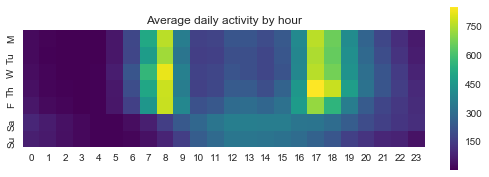

In [16]:
dayTimeHeatmap(trips,isRain)
# this is simply a sum of trips: should be normalized by # of windy days

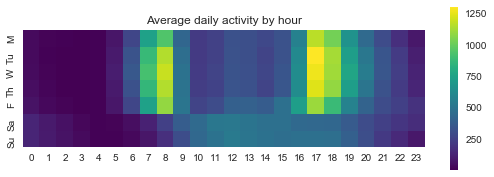

In [17]:
dayTimeHeatmap(trips,isHot)

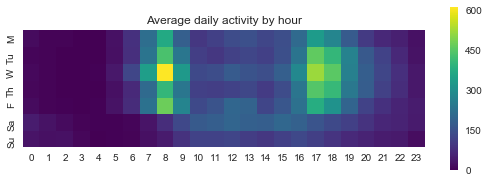

In [18]:
dayTimeHeatmap(trips,isCold)

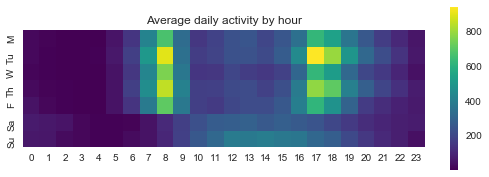

In [19]:
dayTimeHeatmap(trips,isWindy)

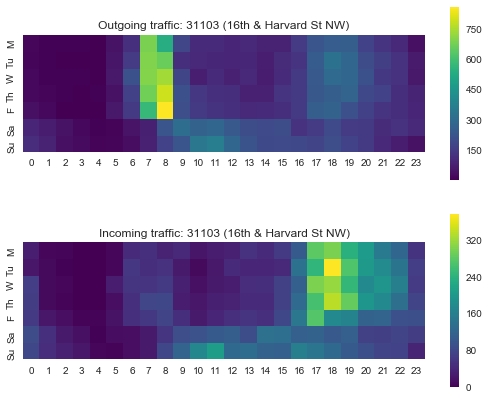

In [20]:

def plotHeatmap(predicate,ax):
    df = trips[predicate]
    df = df.groupby([df.date.map(lambda dt: dt.isoweekday()), df.hour]).size() 
    heatmapdata = np.zeros((7,24))
    for (ind1,ind2),count in df.iteritems():
        heatmapdata[ind1-1,ind2] = count
    sns.heatmap(heatmapdata,
            yticklabels=['M','Tu','W','Th','F','Sa','Su'],
            cmap='viridis',
            square=True,
            ax=ax)

def plotIncomingOutgoing(station):
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(9,7)
    
    plotHeatmap(trips['Start station number'] == station, ax1)
    plotHeatmap(trips['End station number'] == station, ax2)

    ax1.set_title("Outgoing traffic: %i (%s)" % (station, stationData.name.loc[station]))
    ax2.set_title("Incoming traffic: %i (%s)" % (station, stationData.name.loc[station]))

#stationNumber = 31103
#fig, (ax1,ax2) = plt.subplots(2,1)
#fig.set_size_inches(9,7)
plotIncomingOutgoing(31103)   

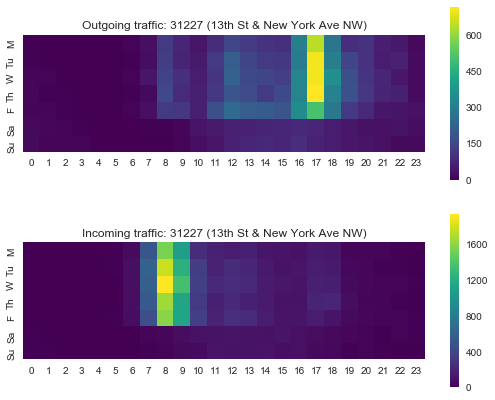

In [21]:
plotIncomingOutgoing(31227)

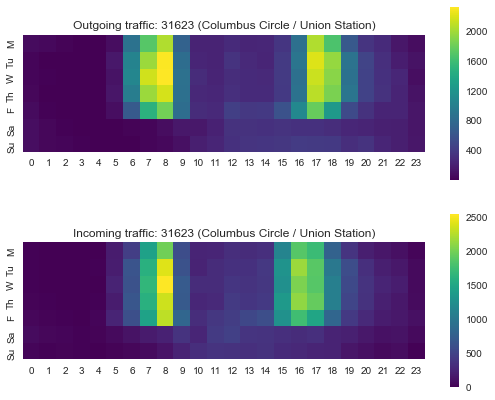

In [22]:
plotIncomingOutgoing(31623)

In [23]:
# plot heatmap showing trips to metro

In [24]:

print weekday.groupby(['Start station number', 'Start station']).size().nlargest(10)
print weekday.groupby(['End station number', 'End station']).size().nlargest(10)


Start station number  Start station                                      
31623.0               Columbus Circle / Union Station                        71524
31200.0               Massachusetts Ave & Dupont Circle NW                   44934
31241.0               Thomas Circle                                          36494
31201.0               15th & P St NW                                         35409
31229.0               New Hampshire Ave & T St NW                            29774
31101.0               14th & V St NW                                         28974
31613.0               Eastern Market Metro / Pennsylvania Ave & 7th St SE    27781
31600.0               5th & K St NW                                          26967
31624.0               North Capitol St & F St NW                             26863
31603.0               1st & M St NE                                          24798
dtype: int64
End station number  End station                                        
31623.0    

,name,railDist,capacity,traffic
terminalName,,,,
31623,Columbus Circle / Union Station,178.786522,47,144225.0
31200,Massachusetts Ave & Dupont Circle NW,95.017507,44,94340.0
31201,15th & P St NW,797.354569,19,73875.0
31241,Thomas Circle,518.596174,32,70144.0


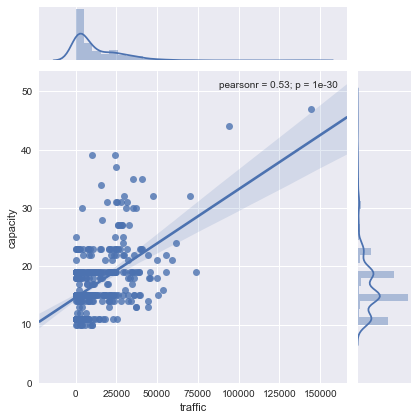

In [25]:
stationTraffic = weekday.groupby('Start station number').size() + \
    weekday.groupby('End station number').size()
stationData['traffic'] = stationTraffic.fillna(0)

sns.jointplot(stationData.traffic, stationData.capacity, kind="reg")
plt.ylim(0,None)
# kind : { “scatter” | “reg” | “resid” | “kde” | “hex” }, optional
#plt.title("Station capacity vs actual traffic")
stationData.nlargest(4,'traffic')[['name','railDist','capacity','traffic']]

In [26]:
stationData.capacity.describe()

count    439.000000
mean      16.902050
std        5.559719
min       10.000000
25%       14.000000
50%       15.000000
75%       19.000000
max       47.000000
Name: capacity, dtype: float64

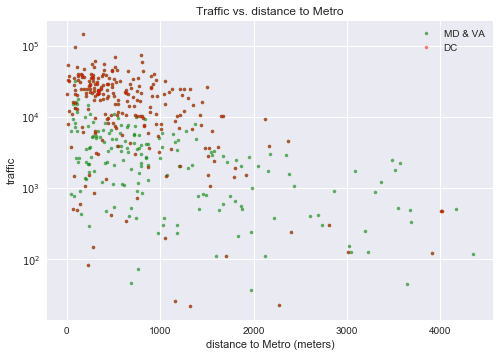

In [27]:
temp = pd.DataFrame.from_dict({'distance': np.log(stationData.railDist),
                               'traffic': np.log(stationData.traffic)}).dropna(0)
#sns.jointplot(temp['distance to metro'], temp['traffic'])
#fig,(ax1,ax2) = plt.subplots(1,2)
#temp.head()
plt.figure()
#plt.scatter(temp['distance'], temp['traffic'])
plt.semilogy(stationData.railDist, stationData.traffic,'g.', alpha=0.6, label='MD & VA')
#sns.jointplot(stationData.railDist, stationData.traffic, kind="reg", ax=ax2)
# correlation is negative, but majority o fstations (including high-traffic) are not close to metro
# 
#temp = temp.dropna(0, subset=['elevation'])
temp = stationData[stationData.elevation > 0]
plt.plot(temp['railDist'], temp['traffic'],'r.', alpha=0.5, label='DC')
plt.xlabel('distance to Metro (meters)')
plt.ylabel('traffic')
plt.legend(loc='best')
plt.title('Traffic vs. distance to Metro')

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_size_inches(11,4)
sns.distplot(stationTraffic.fillna(0),bins=100,ax=ax1)
ax1.set_xlabel('station traffic')
sns.distplot(stationData.capacity,ax=ax2)

ax3.scatter(stationData.traffic, stationData.capacity)
ax3.set_ylim([0,None])
ax3.set_xlabel('station traffic')
ax3.set_ylabel('station capacity')
ax3.set_title('station capacity vs. overall traffic')
#plt.ylim([0, 50])

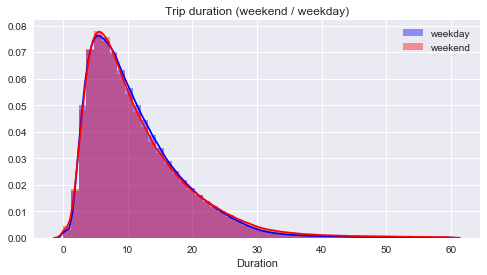

In [28]:
fig = plt.figure()
ax = plt.gca()
fig.set_size_inches(8,4)
sns.distplot(weekday.Duration[weekday.Duration < 3600] / 60.0, color='b', ax=ax, label='weekday')
sns.distplot(weekend.Duration[weekend.Duration < 3600] / 60.0, color='r', ax=ax, label='weekend')
#ax.set_xlim(0,60)
ax.set_title('Trip duration (weekend / weekday)')
ax.legend(loc='best')

fig = plt.figure()
fig.set_size_inches(8,4)
plt.scatter(stationData.traffic, stationData.capacity)
plt.ylim([0,None])
plt.xlabel('station traffic')
plt.ylabel('station capacity')
plt.title('station capacity vs. overall traffic')
plt.ylim([0, 50])

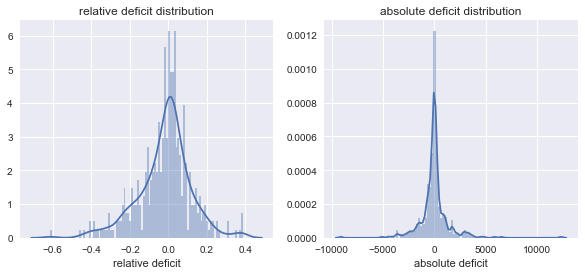

In [29]:
def flux(df):
    start = df.groupby('Start station number').size().fillna(0)
    end = df.groupby('End station number').size().fillna(0)
    return end - start
#stationDeficit = Q1weekday.groupby('End station number').size().fillna(0) - \
#    Q1weekday.groupby('Start station number').size().fillna(0)
stationDeficit = flux(weekday)
relativeDeficit = (stationDeficit / stationTraffic).fillna(0)

#fig = plt.figure()
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,4)
sns.distplot(relativeDeficit,bins=100,ax=ax1)
ax1.set_xlabel('relative deficit')
ax1.set_title('relative deficit distribution')

sns.distplot(stationDeficit.fillna(0),bins=100,ax=ax2)
ax2.set_xlabel('absolute deficit')
ax2.set_title('absolute deficit distribution')


In [30]:
gainers = relativeDeficit.nlargest(20)
losers = relativeDeficit.nsmallest(20)
absoluteGainers = stationDeficit.nlargest(10)
absoluteLosers = stationDeficit.nsmallest(10)
stationData.loc[losers.index]
#stationData.loc[gainers.index]

,name,x,y,lat,long,railDist,closestRail,elevation,capacity,pixel,traffic
End station number,,,,,,,,,,,
31072.0,31st & Woodrow St S,318183.363598,4.300847e+06,38.837666,-77.094820,4163.508269,C08,NaN,11,"(2651.97783881, 17970.324723)",501.0
31700.0,Good Hope & Naylor Rd SE,329314.554343,4.303091e+06,38.860100,-76.967200,2807.936846,D07,85.000000,10,"(13731.0069471, 15483.7566106)",300.0
31316.0,Yuma St & Tenley Circle NW,319693.259603,4.312863e+06,38.946182,-77.080590,199.318741,A07,122.889999,19,"(3898.05546569, 5925.38600725)",1057.0
31123.0,14th & Girard St NW,323820.287214,4.310449e+06,38.925284,-77.032375,377.705063,E04,59.720001,23,"(8076.87966237, 8247.83274304)",4794.0
31701.0,Branch & Pennsylvania Ave SE,329969.682990,4.304087e+06,38.869200,-76.959900,2404.484086,D08,48.869999,11,"(14364.1475632, 14473.3369853)",242.0
31306.0,39th & Calvert St NW / Stoddert,319921.381735,4.310244e+06,38.922649,-77.077271,2125.546298,A05,92.720001,19,"(4183.56062175, 8538.00207034)",9440.0
31093.0,21st St N & N Pierce St,319770.828562,4.307620e+06,38.898984,-77.078317,651.293737,C05,NaN,14,"(4090.60165205, 11164.9336588)",3625.0
32039.0,Old Georgetown Rd & Southwick St,317312.348769,4.318853e+06,38.999634,-77.109647,1074.222158,A10,NaN,18,"(1386.29912365, -10.9172495216)",1530.0
31303.0,Tenleytown / Wisconsin Ave & Albemarle St NW,319801.565859,4.313018e+06,38.947607,-77.079382,30.098206,A07,118.379997,15,"(4002.91173082, 5767.29001614)",12159.0


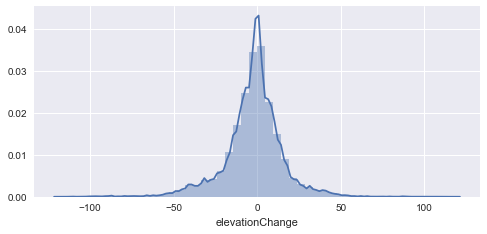

In [31]:
# Get elevation differences
# implicitly identifies DC via existence of DEM data
startElevations = stationData['elevation'].get(trips['Start station number'])
endElevations = stationData['elevation'].get(trips['End station number'])
elevationChange = endElevations.values - startElevations.values
trips['elevationChange'] = elevationChange

dcdata = trips.dropna(axis=0,subset=['elevationChange'])

#counts,bins = np.histogram(dcdata['elevationChange'],50)
plt.figure().set_size_inches(8,3.5)
#plt.plot(0.5*bins[:-1]+0.5*bins[1:], counts)
sns.distplot(dcdata['elevationChange'])

In [32]:


def showFlux(df, n=5, printTop=False):
#    stationDeficit = flux(Q1[Q1['weekday']].dropna(axis=0,subset=['elevationChange']))
    trafficDC = stationData['traffic'][stationData.elevation > 0]
    stationDeficit = flux(df)
#    relativeDeficit = (stationDeficit / stationTraffic).fillna(0)
    relativeDeficit = (stationDeficit / trafficDC).fillna(0)

    gainers = relativeDeficit.nlargest(n)
    losers = relativeDeficit.nsmallest(n)
    absoluteGainers = stationDeficit.nlargest(n)
    absoluteLosers = stationDeficit.nsmallest(n)
    stationData.loc[losers.index]
    #stationData.loc[gainers.index]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(8,6)
    
    def show(data,ax):
        red,blue = data
        ax.imshow(img,cmap='viridis')
        ax.grid(False)
        for row in stationData.loc[red.index].dropna(axis=0,subset=['elevation']).itertuples():
            x,y = row.pixel
            ax.plot(x/16,y/16,'.',c='r')
        for row in stationData.loc[blue.index].dropna(axis=0,subset=['elevation']).itertuples():
            x,y = row.pixel
            ax.plot(x/16,y/16,'.',c='b')
            
    show((gainers,losers),ax1)
    ax1.set_title("Top relative sources & sinks")
    show((absoluteGainers,absoluteLosers),ax2)
    ax2.set_title("Top absolute sources & sinks")

    if printTop:
        print "Relative sinks"
        print stationData['name'].loc[gainers.index]
        print "relative sources"
        print stationData['name'].loc[losers.index]
        print "Absolute sinks"
        print stationData['name'].loc[absoluteGainers.index]
        print "Absolute sources"
        print stationData['name'].loc[absoluteLosers.index]


In [33]:
def showFluxCmap(df):
    #cmap = cm.plasma
    cmap = cm.bwr
    trafficDC = stationData['traffic'][stationData.elevation > 0]
    stationDeficit = flux(df)
    relativeDeficit = (stationDeficit / trafficDC).fillna(0)

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(8,6)
    
    def collect(data):
        for idx,count in data.iteritems():
            row = stationData.loc[idx]
            if row.elevation > 0:
                x,y = row.pixel
                yield x,y,count
    
    def show(data,ax):
        ax.imshow(img,cmap='bone')
        ax.grid(False)
        points = list(collect(data))
        _,_,fluxes = zip(*points)
        scale = 128.0 / max(map(abs,fluxes))
        for x,y,count in points:
            #print count
            if np.isnan(count):
                continue
            cind = 128 + int(count * scale)
            #print cind
            #color = cmap.colors[cind]
            color = cmap(cind)
            alpha = abs(cind-128)/128.0
            ax.plot(x/16,y/16,'.',c=color, alpha=alpha**0.5)
            
    show(relativeDeficit,ax1)
    ax1.set_title("relative sources & sinks")
    show(stationDeficit,ax2)
    ax2.set_title("absolute sources & sinks")

Relative sinks
31812.0              16th & Q St SE / Anacostia HS
31227.0                  13th St & New York Ave NW
31805.0            Pennsylvania & Minnesota Ave SE
31711.0                        Deanwood Rec Center
31710.0    Nannie Helen Burroughs Ave & 49th St NE
Name: name, dtype: object
relative sources
31700.0                        Good Hope & Naylor Rd SE
31123.0                             14th & Girard St NW
31701.0                    Branch & Pennsylvania Ave SE
31316.0                      Yuma St & Tenley Circle NW
31303.0    Tenleytown / Wisconsin Ave & Albemarle St NW
Name: name, dtype: object
Absolute sinks
End station number
31227.0               13th St & New York Ave NW
31205.0                          21st & I St NW
31200.0    Massachusetts Ave & Dupont Circle NW
31246.0              M St & Pennsylvania Ave NW
31108.0                           4th & M St SW
Name: name, dtype: object
Absolute sources
End station number
31103.0                            16th & Har

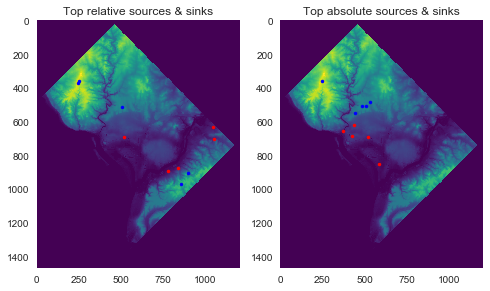

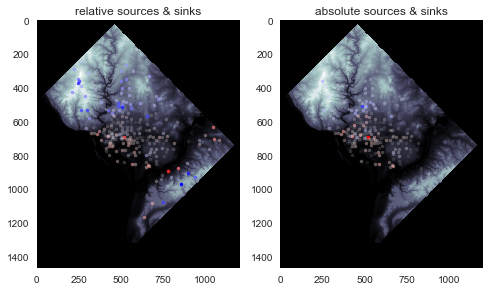

In [34]:
dcWeekday = trips[trips['weekday']].dropna(axis=0, subset=['elevationChange'])
showFlux(dcWeekday,5,True)
showFluxCmap(dcWeekday)

    ax1.imshow(img,cmap='viridis')
    ax2.imshow(img,cmap='viridis')
    #ax = plt.gca()
    for ax in (ax1,ax2): 
        ax.grid(False)
        #ax.hold(True)
    for row in stationData.loc[gainers.index].dropna(axis=0,subset=['elevation']).itertuples():
        x,y = row.pixel
        ax1.plot(x/16,y/16,'.',c='r')
    for row in stationData.loc[losers.index].dropna(axis=0,subset=['elevation']).itertuples():
        x,y = row.pixel
        ax1.plot(x/16,y/16,'.',c='b')
    ax1.set_title("Top relative sources & sinks")

    for row in stationData.loc[absoluteGainers.index].dropna(axis=0,subset=['elevation']).itertuples():
        x,y = row.pixel
        ax2.plot(x/16,y/16,'.',c='r')
    for row in stationData.loc[absoluteLosers.index].dropna(axis=0,subset=['elevation']).itertuples():
        x,y = row.pixel
        ax2.plot(x/16,y/16,'.',c='b')
    ax2.set_title("Top absolute sources & sinks")


Relative sinks
31259.0            20th St & Virginia Ave NW
31227.0            13th St & New York Ave NW
31235.0        19th St & Constitution Ave NW
31217.0    USDA / 12th & Independence Ave SW
31205.0                       21st & I St NW
Name: name, dtype: object
relative sources
31514.0                 Hamlin & 7th St NE
31513.0         Rhode Island Ave & V St NE
31406.0                14th & Upshur St NW
31405.0        Georgia Ave & Emerson St NW
31306.0    39th & Calvert St NW / Stoddert
Name: name, dtype: object
Absolute sinks
31227.0           13th St & New York Ave NW
31233.0    17th & K St NW / Farragut Square
31205.0                      21st & I St NW
31277.0                      17th & G St NW
31230.0       Metro Center / 12th & G St NW
Name: name, dtype: object
Absolute sources
31103.0                         16th & Harvard St NW
31622.0                               13th & D St NE
31619.0    Lincoln Park / 13th & East Capitol St NE 
31229.0                  New Hampshire 

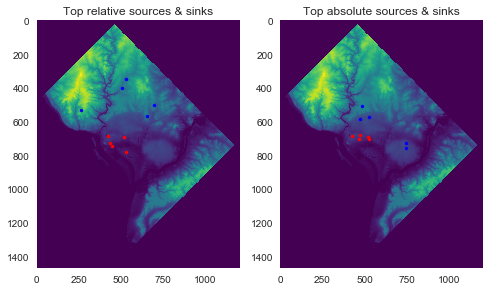

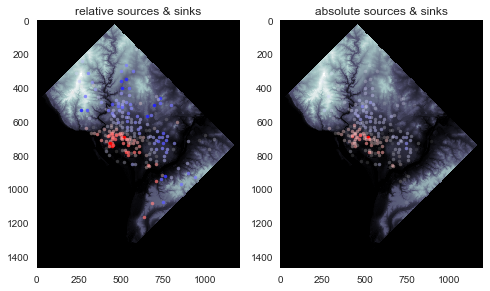

In [35]:
#dcAM = dcWeekday[morning]
amFilter = (trips.weekday) & morning
dcAM = trips[amFilter].dropna(axis=0,subset=['elevationChange'])
showFlux(dcAM, n=5, printTop=True)
showFluxCmap(dcAM)

Relative sinks
31805.0    Pennsylvania & Minnesota Ave SE
31803.0          Good Hope Rd & 14th St SE
31514.0                 Hamlin & 7th St NE
31511.0                12th & Irving St NE
31614.0                     11th & H St NE
Name: name, dtype: object
relative sources
31259.0            20th St & Virginia Ave NW
31217.0    USDA / 12th & Independence Ave SW
31291.0                       16th & K St NW
31287.0          10th St & L'Enfant Plaza SW
31235.0        19th St & Constitution Ave NW
Name: name, dtype: object
Absolute sinks
31101.0                               14th & V St NW
31268.0                               12th & U St NW
31229.0                  New Hampshire Ave & T St NW
31622.0                               13th & D St NE
31619.0    Lincoln Park / 13th & East Capitol St NE 
Name: name, dtype: object
Absolute sources
31277.0                       17th & G St NW
31217.0    USDA / 12th & Independence Ave SW
31233.0     17th & K St NW / Farragut Square
31242.0        18t

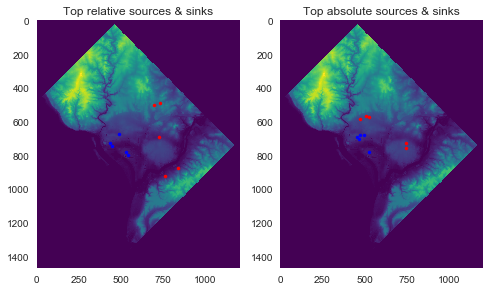

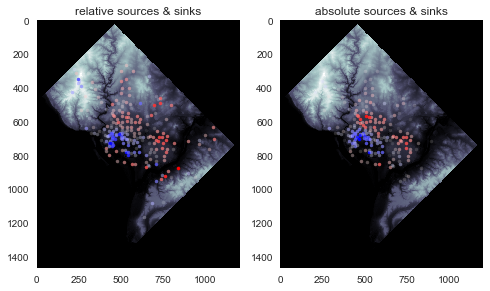

In [36]:
pmFilter = (trips.weekday) & afternoon
dcPM = trips[pmFilter].dropna(axis=0,subset=['elevationChange'])
#dcPM = dcWeekday[afternoon]
showFlux(dcPM, n=5, printTop=True)
showFluxCmap(dcPM)

stationData.loc[absoluteGainers.index].dropna(axis=0,subset=['elevation'])

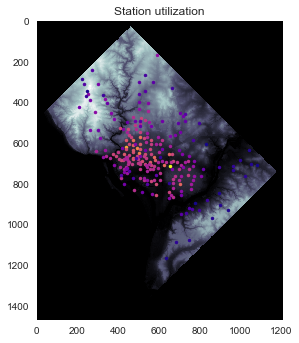

In [37]:

cmap = cm.plasma.colors
scalefactor = 1.0 / stationTraffic.max()
plt.figure()
plt.imshow(img,cmap='bone')
ax = plt.gca()
ax.grid(False)
for station in stationData.itertuples():
    if station.elevation > 0:
        try:
            trafficVal = stationTraffic.loc[station[0]]
            x,y = dem.proj(station.long,station.lat)
            x,y = dem.map2raster(x,y)
            cind = int((trafficVal * scalefactor) ** 0.5 * 255)
            color = cmap[cind]
            ax.plot(x/16,y/16,'.',c=color)
        except:
            continue
plt.title("Station utilization")

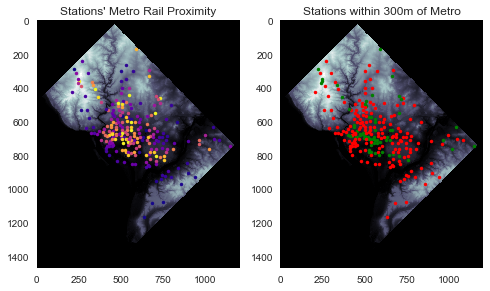

In [38]:
cmap = cm.plasma
#scalefactor = 1.0 / stationTraffic.max()
#plt.figure()
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img,cmap='bone')
ax2.imshow(img,cmap='bone')
ax1.grid(False); ax2.grid(False)

for station in stationData.itertuples():
    if station.elevation > 0:
        try:
            isMetro = station.railDist < 300
            x,y = dem.proj(station.long,station.lat)
            x,y = dem.map2raster(x,y)
#            cval = np.tanh((station.railDist - 300) / 100)
            cval = np.tanh(np.log(300 / station.railDist ))
            cind = int(cval * cmap.N)
            color = cmap.colors[cind]
            ax1.plot(x/16,y/16,'.',c=color)
            color = 'g' if isMetro else 'r'
            ax2.plot(x/16,y/16,'.',c=color)
            
        except:
            continue
ax1.set_title("Stations' Metro Rail Proximity")
ax2.set_title("Stations within 300m of Metro")

#import matplotlib
#matplotlib.colors.get_named_colors_mapping()
cmap = matplotlib.colors.Colormap('viridis')
print cmap.__doc__
print matplotlib.cm.viridis.__doc__
matplotlib.cm.viridis.colors[13]

pd.merge(Q1[['Start station number','End station number']],
         stationDataDC[['name','elevation']],
         left_on='Start station number',
         right_index=True)

explained variation: 0.190
-0.0164313070012
explained variation: 0.382
-0.0183323115956


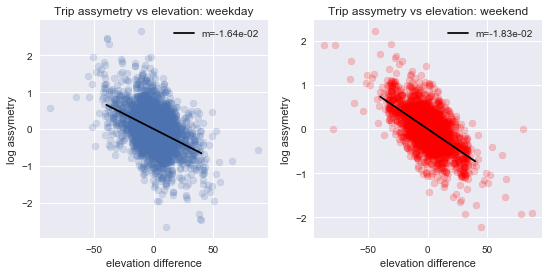

In [39]:
data = dcdata[['Start station number','End station number','elevationChange']]

import statsmodels.api as sm
def plotAssymetry(data, ax=None, thresh=100, **kwargs):
    
    pathCounts = data.groupby(['Start station number', 'End station number']).size()
    pathDeltas = data['elevationChange'].groupby([data['Start station number'],
                                                data['End station number']]).mean()

    pathCountsReverse = data.groupby(['End station number', 'Start station number']).size().reindex(pathCounts.index)
    symm = pathCounts + pathCountsReverse
#    assym = (pathCounts - pathCountsReverse).astype(np.float) / symm
    assym = np.log(pathCounts / pathCountsReverse.astype(np.float))
    x = pathDeltas[symm > thresh]
    y = assym[symm > thresh]
    if (ax is None):
        plt.figure()
        ax = plt.gca()
#    sns.regplot(x, y, ax=ax, **kwargs)
    ax.scatter(pathDeltas[symm > thresh], assym[symm > thresh], alpha=0.2, **kwargs)
    ax.set_xlabel('elevation difference')
    ax.set_ylabel('log assymetry')
    
    X = sm.add_constant(x)
    model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    m,b = fit.params[1], fit.params[0]
    y1 = y - m*x - b
    v,v1 = y.var(),y1.var()
    print "explained variation: %0.3f" % ((v-v1)/v)
    print m
    ax.plot([-40,40], [-40*m,40*m],'k', label="m=%0.2e" % (m))
    ax.legend(loc='best')

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(9,4)
#fig = plt.figure(); ax = plt.gca()
plotAssymetry(data[ map(lambda dt: dt.isoweekday() < 6, dcdata['Start date']) ], 
              ax=ax1, thresh=300, ) #label='weekday')
plotAssymetry(data[ map(lambda dt: dt.isoweekday() > 5, dcdata['Start date']) ], 
              ax=ax2, thresh=100, color='r', ) #label='weekend')
#plt.legend(loc='best')
#plt.title('Trip assymetry vs. elevation change')
ax1.set_title("Trip assymetry vs elevation: weekday")
ax2.set_title("Trip assymetry vs elevation: weekend")
# weekend assymetry is well explained by elevation
# weekday: has some assymetric routes with low elevation change 

an attempt to repeat above plot isolating data near metro stations.
however it is causing errors.
data = dcdata[['Start station number','End station number','elevationChange']]
metroStartDist = stationData.railDist.loc[data['Start station number']]
metroStart = metroStartDist < 300.0
data = data[metroStart]
metroStart = stationData.railDist.loc[data['Start station number']] < 300 
metroEnd = stationData.railDist.loc[data['End station number']] < 300 
metroBoth = metroStart & metroEnd
data = data[ metroStart ]
fig = plt.figure(); ax = plt.gca()
plotAssymetry(data, ax=ax, thresh=300, ) #label='weekday')

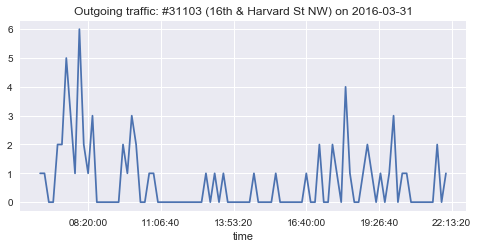

In [40]:
# Looking for evidence of a station with no empty docks.
# 31623 is largest traffic (also high traffic:capacity ratio)
# Try a top absolute or relative sink instead: 31103

station = 31103
date = datetime.date(2016,3,31)
def plotOutgoingTraffic(station,date):
    mytrips = trips[(trips['Start station number'] == station) & (trips['date'] == date)][['Start date','End station number']].set_index('Start date') 
    mytrips.index = pd.DatetimeIndex(mytrips.index)
    buckets = mytrips.resample('10Min').size()
#trips.resample('5Min')
    plt.figure().set_size_inches(8,3.5)
    plt.plot(buckets.index.time, buckets)
    plt.title("Outgoing traffic: #%i (%s) on %s" % (station, stationData['name'][station],date.__str__()))

def plotIncomingTraffic(station,date):
    mytrips = trips[(trips['End station number'] == station) & (trips['date'] == date)][['End date','Start station number']].set_index('End date') 
    mytrips.index = pd.DatetimeIndex(mytrips.index)
    buckets = mytrips.resample('10Min').size()
#trips.resample('5Min')
    plt.figure().set_size_inches(8,3.5)
    plt.plot(buckets.index.time, buckets)
    plt.title("Incoming traffic: #%i (%s) on %s" % (station, stationData['name'][station], date.__str__()))

plotOutgoingTraffic(station,date)


Further questions:
* is the trip a substitue for metro (start & end both near metro)
* weather?
* evidence of station at capacity
